# Continuous normalizing flows 

### In pytorch

**Goal:** Train a CNF by integrating the ODE to get the likelihood and evaluate the model permormance.

**Your tasks:**
- Train w/ the NLL
- (Will probably create some viz tasks too...)

**Resources:** Working from this excellent torchdiffeq [example](https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py).

Nicole Hartman 

ODSL GenAI Days

25 Sept 2024

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Some global configs
adjoint=True
viz=True
niters=750
lr=1e-3
num_samples=512
hidden_dim=64

if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [2]:
class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim):
        super().__init__()
        
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        
        self.phi = nn.Sequential(nn.Linear(in_out_dim+1,hidden_dim),nn.Tanh(),
                                 nn.Linear(hidden_dim,hidden_dim),nn.Tanh(),
                                 nn.Linear(hidden_dim,in_out_dim)
                                )
    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.phi(torch.concatenate([z,t*torch.ones(batchsize,1)],axis=1))
            
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()




In [3]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


### Datasets

In [4]:
mu = 5.
std = 1.
# from sklearn.datasets import make_circles

def get_batch(num_samples):
    z = torch.randn(num_samples,1).type(torch.float32).to(device)
    x = mu + std * z
    
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    return(x, logp_diff_t1)



In [5]:
logp_diff_t1.shape

NameError: name 'logp_diff_t1' is not defined

In [6]:
t0 = 0
t1 = 1
device = 'cpu'


In [6]:
in_out_dim=1

# model
func = CNF(in_out_dim=in_out_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(func.parameters(), lr=lr)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0]).to(device),
    covariance_matrix=torch.tensor([[1.]]).to(device)
)

losses = []

loss_meter = RunningAverageMeter()

for itr in range(1, niters + 1):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(num_samples)

    z_t, logp_diff_t = odeint(
        func,
        (x, logp_diff_t1),
        torch.tensor([t1, t0]).type(torch.float32).to(device),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    loss = -logp_x.mean(0)

    loss.backward()
    optimizer.step()

    loss_meter.update(loss.item())

    losses.append(loss_meter.avg)
    if itr % 50==0:
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))
    # break

Iter: 50, running avg loss: 10.7204
Iter: 100, running avg loss: 7.2051
Iter: 150, running avg loss: 5.0195
Iter: 200, running avg loss: 3.6569
Iter: 250, running avg loss: 2.8065
Iter: 300, running avg loss: 2.2765
Iter: 350, running avg loss: 1.9450
Iter: 400, running avg loss: 1.7417
Iter: 450, running avg loss: 1.6178
Iter: 500, running avg loss: 1.5445
Iter: 550, running avg loss: 1.4987
Iter: 600, running avg loss: 1.4691
Iter: 650, running avg loss: 1.4490
Iter: 700, running avg loss: 1.4374
Iter: 750, running avg loss: 1.4331


Text(0, 0.5, 'Negative log likelihood')

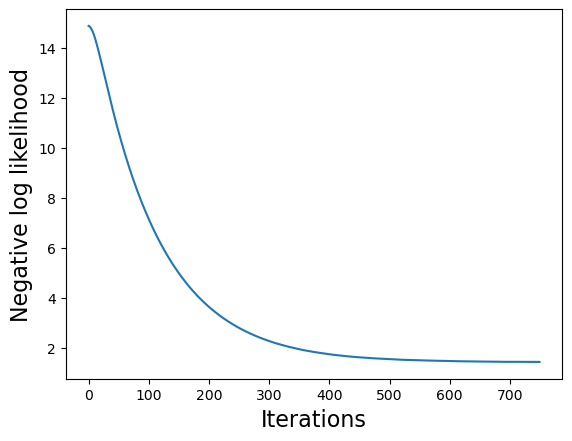

In [7]:
plt.plot(losses)
plt.xlabel('Iterations',fontsize=16)
plt.ylabel('Negative log likelihood',fontsize=16)

In [8]:
viz_timesteps = 11
viz_samples = 30000


# Generate evolution of density
z_t1 = torch.linspace(-5, 10, 100).view(-1,1).type(torch.float32).to(device)
logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(device)

print('z_t1',z_t1.shape)
print('logp_diff_t1',logp_diff_t1.shape)


with torch.no_grad():
    # Generate evolution of samples
    z_t0 = p_z0.sample([viz_samples]).to(device)
    logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)

    print('z_t0',z_t0.shape)
    print('logp_diff_t0',logp_diff_t0.shape)
    
    z_t_samples, _ = odeint(
        func,
        (z_t0, logp_diff_t0),
        torch.tensor(np.linspace(t0, t1, viz_timesteps)).to(device),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )
    
    z_t_density, logp_diff_t = odeint(
        func,
        (z_t1, logp_diff_t1),
        torch.tensor(np.linspace(t1, t0, viz_timesteps)).to(device),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

z_t1 torch.Size([100, 1])
logp_diff_t1 torch.Size([100, 1])
z_t0 torch.Size([30000, 1])
logp_diff_t0 torch.Size([30000, 1])


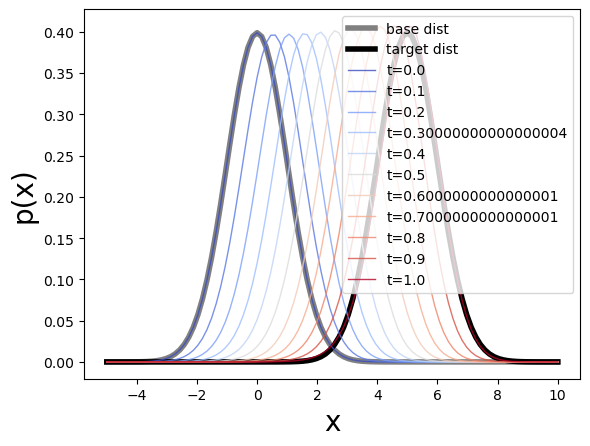

In [9]:
# fig, ax = plt.subplots(1,1)

# Base density
plt.plot(z_t1.view(-1).numpy(), 
         np.exp(p_z0.log_prob(z_t1).numpy()),
         'grey',lw=4,
         label='base dist')

# Target density
p_z1 = torch.distributions.MultivariateNormal(
            loc=torch.tensor([mu]).to(device),
            covariance_matrix=torch.tensor([[std**2]]).to(device)
        )
plt.plot(z_t1.view(-1).numpy(), 
         np.exp(p_z1.log_prob(z_t1).numpy()),
         'k',lw=4,label='target dist')

plt.legend(loc='upper left',fontsize=18)

plt.xlabel('x',fontsize=20)
plt.ylabel('p(x)',fontsize=20)

timesteps = np.linspace(t0, t1, viz_timesteps)
cmap = mpl.colormaps['coolwarm']
colors = cmap( timesteps/t1 ) # norm timesteps by t1 b/c cmap expects a num b/w (0,1)

for (t, z_density, logp_diff, c) in zip(timesteps, z_t_density, logp_diff_t,colors):
    logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
    plt.plot(z_t1.detach().cpu().numpy(),
             np.exp(logp.detach().cpu().numpy()), 
             color=c,label=f't={t}',lw=1,alpha=.8)

plt.legend(loc='upper right')

plt.show()

Hmmmm, this plot is a little busy... let's look at what's going on here :)

In [10]:
z_t_density.shape

torch.Size([11, 100, 1])

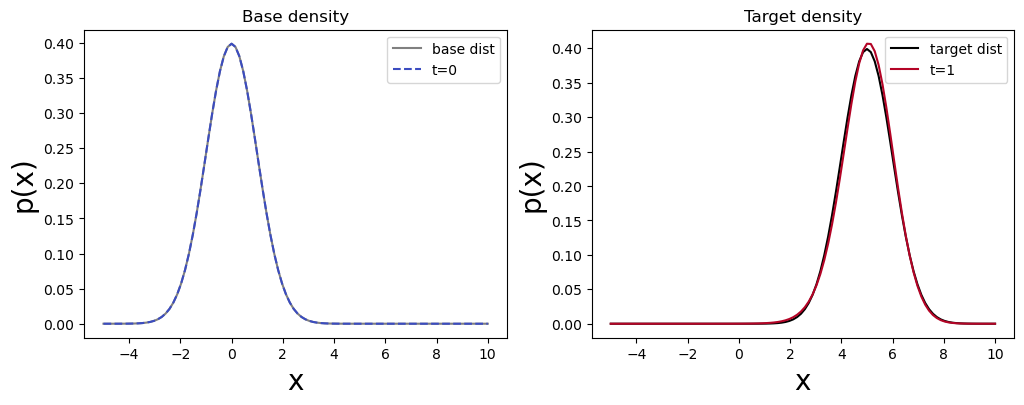

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

# Base density
ax[0].plot(z_t1.view(-1).numpy(), 
         np.exp(p_z0.log_prob(z_t1).numpy()),
         'grey',
         label='base dist')

# Pred by NODE at timestep 0
logp = p_z0.log_prob(z_t_density[0]) - logp_diff_t[0].view(-1)
ax[0].plot(z_t1.detach().cpu().numpy(),
         np.exp(logp.detach().cpu().numpy()), 
         color=colors[0],label=f't={t0}',ls='--')

ax[0].set_xlabel('x',fontsize=20)
ax[0].set_ylabel('p(x)',fontsize=20)
ax[0].set_title('Base density')
ax[0].legend()

# Target density
ax[1].plot(z_t1.view(-1).numpy(), 
         np.exp(p_z1.log_prob(z_t1).numpy()),
         'k',label='target dist')

# Pred by NODE at timestep t1
logp = p_z0.log_prob(z_t_density[-1]) - logp_diff_t[-1].view(-1)
ax[1].plot(z_t1.detach().cpu().numpy(),
         np.exp(logp.detach().cpu().numpy()), 
         color=colors[-1],label=f't={t1}')


ax[1].set_xlabel('x',fontsize=20)
ax[1].set_ylabel('p(x)',fontsize=20)
ax[1].set_title('Target density')
ax[1].legend()

plt.show()

**Comparing samples**

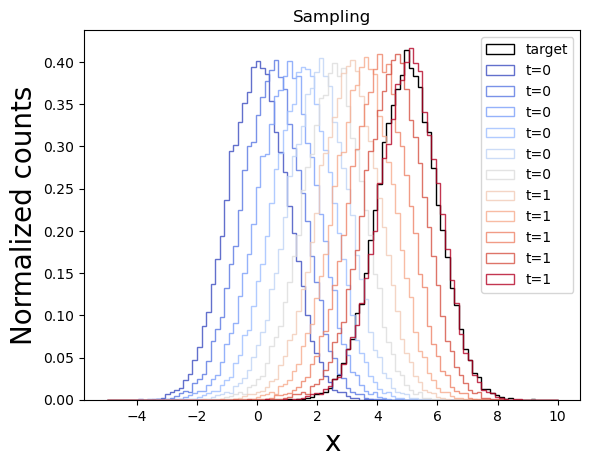

In [12]:
# Target
z_target = get_batch(viz_samples)[0].squeeze()
plt.hist(z_target.numpy(), bins=100,range=(-5,10),
             histtype='step', density=True,
             color='k',label=f'target')

for (t, z_sample, c) in zip(timesteps, z_t_samples, colors):
    
    plt.hist(z_sample.numpy(), bins=100,range=(-5,10),
             histtype='step', density=True,
             color=c,label=f't={t:.0f}',lw=1,alpha=.8)

plt.xlabel('x',fontsize=20)
plt.ylabel('Normalized counts',fontsize=20)
plt.legend(loc='upper right')
plt.title('Sampling')


plt.show()

In [13]:
if viz:
    
    target_sample, _ = get_batch(viz_samples)

    results_dir = "./figures/tmp"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
        # Create plots for each timestep
        for (t, z_sample, z_density, logp_diff,ci) in zip(
                np.linspace(t0, t1, viz_timesteps),
                z_t_samples, z_t_density, logp_diff_t,colors
        ):
            fig = plt.figure(figsize=(12, 4), dpi=200)
            plt.tight_layout()
            plt.axis('off')
            plt.margins(0, 0)
            fig.suptitle(f'{t:.2f}s')

            ax1 = fig.add_subplot(1, 3, 1)
            ax1.set_title('Target')
            
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.set_title('Samples')

            ax3 = fig.add_subplot(1, 3, 3)
            ax3.set_title('Probability')
            ax3.set_ylim(0,0.45)
            
            ax1.hist(*target_sample.detach().cpu().numpy().T, bins=100, density=True,
                     range=[-5, 10])

            ax2.hist(*z_sample.detach().cpu().numpy().T, bins=100, density=True,
                     range=[-5, 10],color=ci)

            logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
            ax3.plot(*z_t1.detach().cpu().numpy(), np.exp(logp.detach().cpu().numpy()),color=ci)

            plt.savefig(os.path.join(results_dir, f"cnf-viz-{int(t*10):05d}.jpg"),
                       pad_inches=0.2, bbox_inches='tight')
            plt.close()

        img, *imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(results_dir, f"cnf-viz-*.jpg")))]
        img.save(fp="figures/cnf-viz.gif", format='GIF', append_images=imgs, save_all=True, duration=250, loop=0)
        os.system(f'rm -rf {results_dir}')
    print('Saved visualization animation at {}'.format("figures/cnf-viz.gif"))

Saved visualization animation at figures/cnf-viz.gif
